# Are we just in the perturbative regime?

In the 2009 paper [Pairwise Maximum Entropy Models for Studying Large Biological Systems: When They Can Work and When They Can't](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000380), Roudi et al. suggest that when we are in the perturbative regime, characterised by a small mean probability of observing neurons spike and small number of neurons $N$, the pairwise maxent model can appear to be a good model for a distribution. However, we cannot extrapolate the behaviour of the pairwise model to larger $N$, and predict that it will remain a good fit outside of the perturbative regime. In short:

> The distance between the pairwise model and **any** probability distribution appears linear in $N\bar{v}\delta t$ in the perturbative regime 

We try and investigate these claims computationally.

The perturbative regime is defined as $N\bar{v}\delta t \ll 1$, where $\bar{v}$ is the mean firing rate and $\delta t$ is the size of the time bin. As shorthand, we define $\delta \doteq \bar{v}\delta t$.  For sufficiently small time bins where we observe at most one spike within each bin, and we can identify $\delta$ with the mean probability of observing a neuron fire. 

As an example, for $N=5$ neurons, we should be in the perturbative regime with $\bar{p}(r_i=1)=\delta \ll 0.2$.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from NumericIsing import Ising
from ThreeWise import ThreeWise

We try and reproduce the main computational results in the paper. These results show close agreement between the true distance measure between the 'pairwise' and a '3-wise distribution', and an estimate of the distance measure between these distributions, whilst in the perturbative regime. 

First, we create a '3-wise distribution'. More accurately, we define the interactions in a model that includes up to 3-wise interactions, which creates a distribution that cannot be explained by a model that includes only up to pairwise interactions. 

This distribution takes the form:
$$
    P^{(3)}(\{r_i\}) = \frac{1}{Z} \exp \left[ \sum_i h_i r + \sum_{i< j} J_{ij}r_i r_j  + \sum_{i<j<k} K_{ijk}r_i r_j r_k  \right]
$$
From the paper, the interaction terms were determined as:
- $h_i = - \ln (1/r_i^* - 1)$, where each $r_i^*$ is randomly drawn from an exponential distribution with mean 0.02
- $J_{ij}$ is drawn from a Gaussian distribution with mean 0.05 and s.d. 0.8
- $K_{ijk}$ is drawn from a Gaussian distribution with mean 0.02 and s.d. 0.5

In [2]:
def sim_p_true(N):
    """
    Function that creates a distribution that includes up to 3-wise interactions,
    by randomly sampling the interaction weights from the distributions specified in the paper
    """
    h = np.zeros(N)
    for i in range(N):
        h[i] = -np.log(1/np.random.exponential(0.02) - 1)
        
    J = np.zeros((N,N))
    for i in range(N-1):
        for j in range(i+1,N):
            J[i,j] = np.random.normal(0.05, 0.8)
            
    K = np.zeros((N,N,N))
    for i in range(N-2):
        for j in range(i+1,N-1):
            for k in range(j+1,N):
                K[i,j,k] = np.random.normal(0.02, 0.5)
    
    p_true = ThreeWise(N, h, J, K)
    return p_true

In [3]:
p_true = sim_p_true(4)
#calc 3 wise correlations
for i in range(p_true.N-2):
    for j in range(i+1,p_true.N-1):
        for k in range(j+1, p_true.N):
            print(f"Correlation between {i},{j},{k}\n",p_true.expectation(lambda s: s[0]*s[1]*s[2], [i,j,k], p_true.p))

Correlation between 0,1,2
 4.873607574131338e-05
Correlation between 0,1,3
 6.587922158168148e-06
Correlation between 0,2,3
 1.205340759886893e-05
Correlation between 1,2,3
 3.8210339069379875e-05


The main results in the paper are, in the perturbative regime:
- $\Delta_N = D_{K L}\left(p_{\text {true }} \| p_{\text {pair }}\right) / D_{K L}\left(p_{\text {true }} \| p_{\text {ind }}\right)$ scales as $(N-2)\delta + \mathcal{O}\left((N \delta)^{2}\right)$ (I assume the power of 2 is just a safe upper bound). 
- $$D_{K L}\left(p_{\text {true }} \| p_{\text {pair }}\right)=\frac{1}{\ln 2} \sum_{i<j<k} \bar{r}_{i} \bar{r}_{j} \bar{r}_{k} f\left(\bar{\boldsymbol{\rho}}_{ijk}^{\text{true}}, \bar{\boldsymbol{\rho}}_{i j k}^{\text{pair}}\right)+\mathcal{O}\left((N \delta)^{4}\right)$$
- $$D_{K L}\left(p_{\text {true }} \| p_{\text {ind }}\right)=\frac{1}{\ln 2} \sum_{i<j} \bar{r}_{i} \bar{r}_{j} f\left(\rho_{i j}^{\text{true}}, 0\right)+\mathcal{O}\left((N \delta)^{3}\right)$$

The KL divergence is defined as $D_{KL}(p\| q) \doteq \sum_s p_s \log_2 (p_s/q_s) $, where we sum over all states $s$. $f(x,y) \doteq (1+x)\big[\ln(1+x)-\ln(1+y)\big] - (x-y)$, $\overline{r}_i = \langle r \rangle $ (they use $r$ instead of $\sigma$ in the paper), $\rho_{ij}$ is the normalised pairwise correlation defined as:
$$
    \rho_{ij} \doteq \frac{\langle r_i r_j \rangle - \bar{r_i} \bar{r_j}}{\bar{r_i} \bar{r_j}}
$$
and $\bar{\boldsymbol{\rho}}_{i j k}^{p}$ is defined as:
$$
    \bar{\boldsymbol{\rho}}_{i j k}^{p} \doteq \frac{\langle r_i r_j r_k \rangle - \bar{r_i} \bar{r_j} \bar{r_k}}{\bar{r_i} \bar{r_j} \bar{r_k}}
$$
Note, $\bar{\boldsymbol{\rho}}_{i j k}^{p}$ depends on the distribution $p$ that is used to calculate the expectations.

In [4]:
def get_statistics(p):
    avgs = p.averages() #get the averages \bar{r}
    corrs_2 = p.correlations() #get the pairwise correlations <r_i r_j>
    
    N = p.N #how many neurons
    
    #calc all the \rho_{ij}
    rho = np.zeros((N,N))
    for i in range(N-1):
        for j in range(i+1,N):
            rho[i,j]= corrs_2[i,j]/(avgs[i]*avgs[j]) - 1
            
    #calc all the \bar{\rho}_{ijk}
    rho_b = np.zeros((N,N,N))
    corrs_3 = np.zeros((N,N,N))
    for i in range(N-2):
        for j in range(i+1,N-1):
            for k in range(j+1,N):
                corrs_3[i,j,k]= p.expectation(lambda s: s[0]*s[1]*s[2], [i,j,k], p.p) 
                rho_b[i,j,k] = corrs_3[i,j,k] / (avgs[i]*avgs[j]*avgs[k]) - 1
                
    return avgs, corrs_2, corrs_3, rho, rho_b

def f(x,y):
    return (1+x)*(np.log(1+x) - np.log(1+y)) - (x-y)

To test all of this out, let's define a model that models the probability of each neuron firing as being independent. This corresponds to setting the 'local fields' $h_i$ to $\ln(\bar{r}_i/(1-\bar{r}_i))$, and all other interaction parameters to 0. The expectations $\langle r_i r_j ... r_p \rangle$ should purely be products of the expectations of seeing indivdual neurons fire $\bar{r}_i \bar{r}_j ... \bar{r}_p$. Hence, the normalised correlations should all be 0.

In [5]:
N = 4
r_bar = np.ones(N)*0.4
h = -np.log(1/r_bar - 1)
J = np.zeros((N,N))
K = np.zeros((N,N,N))

p_ind = ThreeWise(N,h,J,K)

In [7]:
get_statistics(p_ind) #produces expected stats

(array([0.4, 0.4, 0.4, 0.4]),
 array([[0.  , 0.16, 0.16, 0.16],
        [0.  , 0.  , 0.16, 0.16],
        [0.  , 0.  , 0.  , 0.16],
        [0.  , 0.  , 0.  , 0.  ]]),
 array([[[0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.064, 0.064],
         [0.   , 0.   , 0.   , 0.064],
         [0.   , 0.   , 0.   , 0.   ]],
 
        [[0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.064],
         [0.   , 0.   , 0.   , 0.   ]],
 
        [[0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ]],
 
        [[0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , 0.   ]]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.000

We now randomly instantiate 3-wise models of different sizes $N$ and then fit independent and pairwise models to the averages and pairwise correlations produced by the 3-wise models. At each size, we measure the true KL divergences between the 3-wise model and the independent and pairwise models. We also calculate the KL divergences based on the perturbative results. Finally, we compare the true distances and the distances predicted by the perturbative results.

In [30]:
def get_divergences(N,verb=True):
    # fit true distribution
    p_true = sim_p_true(N)
    avgs_t, corrs_2_t, corrs_3_t, rho_t, rho_b_t = get_statistics(p_true) # get stats

    # fit independent model - set h to -ln(1/avgs_t - 1) and all other params to 0
    p_ind = ThreeWise(N,-np.log(1/avgs_t - 1),np.zeros((N,N)),np.zeros((N,N,N)))

    # fit pairwise distribution
    p_pair = Ising(N, avgs_t, corrs_2_t, lr=0.5) 

    def dist(avgs, corrs, p): # Calcs how far the pairwise models averages and correlations are from the true ones
        m_av = np.mean(avgs) # roughly normalise differences before taking the norm
        m_cor = np.mean(corrs)
        return np.linalg.norm((avgs-p.averages())/m_av, 1) + np.linalg.norm( (corrs-p.correlations())/m_cor,1) 

    d=dist(avgs_t, corrs_2_t, p_pair)
    if verb: print(f"Progress, N={N}:")
    while d > 0.5:
        p_pair.gradient_ascent()
        d=dist(avgs_t, corrs_2_t, p_pair)
        if verb: print(round(d,1),end=" ")

    if verb: print()
    avgs_p, corrs_2_p, corrs_3_p, rho_p, rho_b_p = get_statistics(p_pair) # get stats
    
    if verb:
        print("True stats")
        print(avgs_t,corrs_2_t, sep="\n")
        print("Pairwise stats")
        print(avgs_p,corrs_2_p, sep="\n")

    # calc. actual and perturbative KL divergences
    def D_KL(p,q):
        d = 0
        for s in p.states:
            d += p.p(s)*np.log(p.p(s)/q.p(s))
        return d
    D_KL_pair = D_KL(p_true, p_pair)
    D_KL_ind = D_KL(p_true, p_ind)

    # pert. divergences
    PD_KL_pair = 0
    for i in range(N-2):
        for j in range(i+1,N-1):
            for k in range(j+1,N):
                PD_KL_pair+=avgs_p[i]*avgs_p[j]*avgs_p[k]*f(rho_b_t[i,j,k], rho_b_p[i,j,k])

    PD_KL_pair/=np.log(2)

    PD_KL_ind = 0
    for i in range(N-1):
        for j in range(i+1,N):
            PD_KL_ind+=avgs_p[i]*avgs_p[j]*f(rho_t[i,j], 0)

    PD_KL_ind/=np.log(2)
    
    if verb:
        print("Comparison:")
        print(D_KL_pair,PD_KL_pair)
        print(D_KL_ind,PD_KL_ind)
    
    return D_KL_pair, D_KL_ind, PD_KL_pair, PD_KL_ind

In [59]:
N0 = 3 # starting no. spins
Ns = 3 # range of size of spins we consider
reps = 3 

Store_D_KL_pair = np.zeros((Ns,reps))
Store_D_KL_ind = np.zeros_like(Store_D_KL_pair)
Store_PD_KL_pair = np.zeros_like(Store_D_KL_pair)
Store_PD_KL_ind = np.zeros_like(Store_D_KL_pair)

for n in range(Ns):
    for i in range(reps):
        D_KL_pair, D_KL_ind, PD_KL_pair, PD_KL_ind = get_divergences(N0+n)
        Store_D_KL_pair[n,i] = D_KL_pair
        Store_D_KL_ind[n,i] = D_KL_ind
        Store_PD_KL_pair[n,i] = PD_KL_pair
        Store_PD_KL_ind[n,i] = PD_KL_ind

Progress, N=3:


28.4 27.8 27.3 26.8 26.4 26.1 25.8 25.5 25.2 24.9 24.6 24.3 24.1 23.8 23.6 23.3 23.1 22.9 22.6 22.4 22.2 22.0 21.8 21.6 21.4 21.2 21.0 20.8 20.6 20.4 20.2 20.1 19.9 19.7 19.5 19.4 19.2 19.1 18.9 18.7 18.6 18.4 18.3 18.1 18.0 17.9 17.7 17.6 17.4 17.3 17.2 17.0 16.9 16.8 16.7 16.5 16.4 16.3 16.2 16.1 16.0 15.8 15.7 15.6 15.5 15.4 15.3 15.2 15.1 15.0 14.9 14.8 14.7 14.6 14.5 14.4 14.3 14.2 14.1 14.0 14.0 13.9 13.8 13.7 13.6 13.5 13.4 13.4 13.3 13.2 13.1 13.0 13.0 12.9 12.8 12.7 12.7 12.6 12.5 12.5 12.4 12.3 12.2 12.2 12.1 12.0 12.0 11.9 11.8 11.8 11.7 11.7 11.6 11.5 11.5 11.4 11.3 11.3 11.2 11.2 11.1 11.1 11.0 10.9 10.9 10.8 10.8 10.7 10.7 10.6 10.6 10.5 10.5 10.4 10.4 10.3 10.3 10.2 10.2 10.1 10.1 10.0 10.0 9.9 9.9 9.8 9.8 9.7 9.7 9.7 9.6 9.6 9.5 9.5 9.4 9.4 9.4 9.3 9.3 9.2 9.2 9.2 9.1 9.1 9.0 9.0 9.0 8.9 8.9 8.9 8.8 8.8 8.7 8.7 8.7 8.6 8.6 8.6 8.5 8.5 8.5 8.4 8.4 8.4 8.3 8.3 8.3 8.2 8.2 8.2 8.1 8.1 8.1 8.0 8.0 8.0 7.9 7.9 7.9 7.8 7.8 7.8 7.8 7.7 7.7 7.7 7.6 7.6 7.6 7.6 7.5 7.5 7.5 7.5 7

0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 

3.7 3.1 2.7 2.4 2.2 1.9 1.7 1.6 1.4 1.3 1.3 1.2 1.2 1.2 1.1 1.1 1.1 1.0 1.0 1.0 1.0 0.9 0.9 0.9 0.9 0.9 0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.5 0.5 0.5 0.5 0.5 
True stats
[0.03234113 0.0475063  0.00230926 0.01261197]
[[0.00000000e+00 2.04448439e-03 1.09383840e-04 8.80580070e-04]
 [0.00000000e+00 0.00000000e+00 9.42754149e-05 3.43469423e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.34299934e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Pairwise stats
[0.03234077 0.04750507 0.0023064  0.01260864]
[[0.00000000e+00 2.04942515e-03 1.42373267e-04 8.75883470e-04]
 [0.00000000e+00 0.00000000e+00 1.14522680e-04 4.43566657e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.92909375e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Comparison:
2.9011669874285765e-05 2.0210736020993845e-05
0.00039362905649152857 0.0005146506995101131
Progress, N=5:
20.0 18.2 16.9 15.9 15.0 14.2 13.5 12.8 12.2 11.7 11.2 10

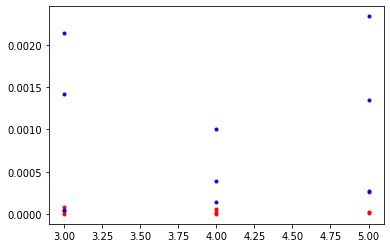

In [65]:
y = Store_D_KL_pair.flatten()
x = (np.ones((Ns,reps)).T*np.arange(N0,N0+Ns)).T.flatten()
plt.plot(x,y,"r.")
y = Store_PD_KL_pair.flatten()
plt.plot(x,y,"b.")
plt.show()

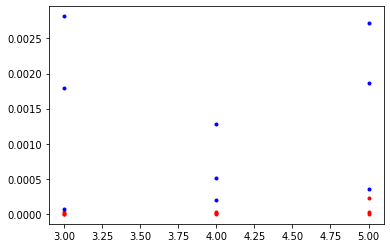

In [66]:
y = Store_D_KL_ind.flatten()
x = (np.ones((Ns,reps)).T*np.arange(N0,N0+Ns)).T.flatten()
plt.plot(x,y,"r.")
y = Store_PD_KL_ind.flatten()
plt.plot(x,y,"b.")
plt.show()

## Modelling toy distributions with the pairwise model

We consider some toy distributions, one that has all neurons firing or not ("All or nothing model"), another which only takes on 2 states ("A couple of states or nothing model") and a third where one of the neurons only fires if only one of the other 2 neurons fire ("XOR").

### All or nothing model
We start by considering a very simple distribution that has higher order correlations. Let us say we have 5 neurons which always fire in sync. Thus $p(1,1,1,1,1) = c$, $p(0,0,0,0,0)=(1-c)$ and all other events have probability 0. The mean firing rate of individual neurons will be c, as will the correlations. We will vary the probability $c$ of all of them firing, and see whether the pairwise model appears to be a good fit. 

In [2]:
N = 5
c = 0.5
avgs = c*np.ones(N) # prob of every neuron firing in a window is 0.5
corrs = c*np.triu(np.ones((N,N)),1) # prob of 2 neurons firing in the same window is 0.2 
print(avgs,corrs, sep="\n")

[0.5 0.5 0.5 0.5 0.5]
[[0.  0.5 0.5 0.5 0.5]
 [0.  0.  0.5 0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0. ]]


In [3]:
p_wise = Ising(N, avgs, corrs, lr=0.5) 

In [4]:
p_wise.gradient_ascent() # 100 steps of gradient ascent. Repeat until accurate. 

In [5]:
print("Predicted averages:", p_wise.averages(), "Predicted correlations:", p_wise.correlations(),sep="\n")

Predicted averages:
[0.53619501 0.53738947 0.54056568 0.54641463 0.55341676]
Predicted correlations:
[[0.53619501 0.51575932 0.51198993 0.50910874 0.50459316]
 [0.         0.53738947 0.505844   0.502652   0.49986001]
 [0.         0.         0.54056568 0.50027544 0.49694551]
 [0.         0.         0.         0.54641463 0.49396977]
 [0.         0.         0.         0.         0.55341676]]


Now that we have trained a maximum entropy model, let us see what it thinks the true probability distribution looks like.

In [6]:
for state in [p_wise.states[0],p_wise.states[-1]]:
    print(state,np.round(p_wise.p(state),2))

[0. 0. 0. 0. 0.] 0.37
[1. 1. 1. 1. 1.] 0.46


Interestingly, the pairwise model is able to accurately predict the full probability distribution of the 'all or nothing model' for different values of $c$. I honestly wasn't sure what to expect here, and would be interested in relating this to the results from the Roudi et al. paper. We will have to consider slightly more complex distributions to 'break' the pairwise model. 

## A couple of states or nothing
The next model that came to mind that takes on two states:

- $p(0,1,1,1,1)=a$
- $p(1,1,1,1,0)=b$
- $p(0,0,0,0,0)=1-(a+b)$

We define $a+b \doteq c$

The expectation of the neurons will be: 

    (b, c, c, c, c, a)

The pairwise correlations will be:

        1 2 3 4 5
      1   b b b 0
      2     c c a    
      3       c a
      4         a

In [74]:
N = 5
a = 0.2
b = 0.4
c = a + b
avgs = np.array([b, c, c, c, a])
corrs = np.array([[0,b,b,b,0],
                  [0,0,c,c,a],
                  [0,0,0,c,a],
                  [0,0,0,0,a]])
print(avgs,corrs, sep="\n")

[0.4 0.6 0.6 0.6 0.2]
[[0.  0.4 0.4 0.4 0. ]
 [0.  0.  0.6 0.6 0.2]
 [0.  0.  0.  0.6 0.2]
 [0.  0.  0.  0.  0.2]]


In [75]:
p_wise = Ising(N, avgs, corrs, lr=0.5) 

In [100]:
p_wise.gradient_ascent() # 100 steps of gradient ascent. Repeat until accurate. 

In [101]:
print("Predicted averages:", p_wise.averages(), "Predicted correlations:", p_wise.correlations(),sep="\n")

Predicted averages:
[0.40120964 0.60166855 0.60201396 0.60243361 0.20180175]
Predicted correlations:
[[0.40120964 0.40017571 0.40004125 0.39989105 0.00277631]
 [0.         0.60166855 0.60019171 0.59988656 0.19942072]
 [0.         0.         0.60201396 0.59956424 0.19928799]
 [0.         0.         0.         0.60243361 0.19916612]
 [0.         0.         0.         0.         0.20180175]]


In [103]:
for state in p_wise.states:
    print(state,np.round(p_wise.p(state),3))

[0. 0. 0. 0. 0.] 0.392
[0. 0. 0. 0. 1.] 0.002
[0. 0. 0. 1. 0.] 0.002
[0. 0. 0. 1. 1.] 0.0
[0. 0. 1. 0. 0.] 0.001
[0. 0. 1. 0. 1.] 0.0
[0. 0. 1. 1. 0.] 0.0
[0. 0. 1. 1. 1.] 0.0
[0. 1. 0. 0. 0.] 0.0
[0. 1. 0. 0. 1.] 0.0
[0. 1. 0. 1. 0.] 0.0
[0. 1. 0. 1. 1.] 0.0
[0. 1. 1. 0. 0.] 0.0
[0. 1. 1. 0. 1.] 0.001
[0. 1. 1. 1. 0.] 0.004
[0. 1. 1. 1. 1.] 0.196
[1. 0. 0. 0. 0.] 0.001
[1. 0. 0. 0. 1.] 0.0
[1. 0. 0. 1. 0.] 0.0
[1. 0. 0. 1. 1.] 0.0
[1. 0. 1. 0. 0.] 0.0
[1. 0. 1. 0. 1.] 0.0
[1. 0. 1. 1. 0.] 0.0
[1. 0. 1. 1. 1.] 0.0
[1. 1. 0. 0. 0.] 0.0
[1. 1. 0. 0. 1.] 0.0
[1. 1. 0. 1. 0.] 0.0
[1. 1. 0. 1. 1.] 0.0
[1. 1. 1. 0. 0.] 0.001
[1. 1. 1. 0. 1.] 0.0
[1. 1. 1. 1. 0.] 0.396
[1. 1. 1. 1. 1.] 0.003


Again, the pairwise model is able to capture the probability distribution.  

## XOR 

In the 2003 Schneidman paper, *Network Information and Connected Correlations*, they say,

> If $\sigma_3$ is formed as the exclusive OR (XOR) of the variables $\sigma_1$ and $\sigma_2$, then the essential structure of $p(\sigma_1,\sigma_2,\sigma_3)$ is contained in a three–spin interaction. 

This might give us a simple example of something the ising model can't model.

Let us say that $\sigma_1$ and $\sigma_2$ firing independently with probabilities $p(\sigma_1{=}1)=a$ and $p(\sigma_2{=}1)=b$. 

        s_1 s_2 s_3  p(s_1, s_2, s_3)
        0   0   0    (1-a)(1-b)
        0   1   1    (1-a)b
        1   0   1    a(1-b)
        1   1   0    ab
Thus, the averages are:

        (a, b, b+a-2ab)

And the correlations are:

        s_1 s_2, s_1 s_3, s_2,s_3
        ab       a(1-b)   (1-a)b        

In [2]:
N = 3
a = 0.2
b = 0.4
avgs = np.array([a,b,b+a-2*a*b])
corrs = np.array([[0,a*b,a*(1-b)],
                  [0,0,(1-a)*b]])
print(avgs,corrs, sep="\n")

[0.2  0.4  0.44]
[[0.   0.08 0.12]
 [0.   0.   0.32]]


In [3]:
p_wise = Ising(3, avgs, corrs, lr=0.5) 

In [18]:
p_wise.gradient_ascent() # 100 steps of gradient ascent. Repeat until accurate. 

In [19]:
print("Predicted averages:", p_wise.averages(), "Predicted correlations:", p_wise.correlations(),sep="\n")

Predicted averages:
[0.20000128 0.40000042 0.44000421]
Predicted correlations:
[[0.20000128 0.08000851 0.11999224]
 [0.         0.40000042 0.31999632]
 [0.         0.         0.44000421]]


In [20]:
for state in p_wise.states:
    print(state,np.round(p_wise.p(state),3))

[0. 0. 0.] 0.406
[0. 0. 1.] 0.074
[0. 1. 0.] 0.074
[0. 1. 1.] 0.246
[1. 0. 0.] 0.074
[1. 0. 1.] 0.046
[1. 1. 0.] 0.006
[1. 1. 1.] 0.074


In [22]:
print([0,0,0], (1-a)*(1-b))
print([0,1,1], (1-a)*b)
print([1,0,1], a*(1-b))
print([1,1,0], a*b)

[0, 0, 0] 0.48
[0, 1, 1] 0.32000000000000006
[1, 0, 1] 0.12
[1, 1, 0] 0.08000000000000002


Notice how the events `[0,0,1]` and `[1,1,1]` are assigned non-zero probabilities, when they should in fact be zero. In general, we can see the predictions are far off. 